In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d

import numpy as np
%matplotlib notebook

In [2]:
def my_transformation_matrix(axis, theta, translation=[0,0,0]):
    """
    Return the transformation matrix associated with the rotation about
    the given axis by theta radians and [xt,yt,zt] translation.
    
    Based on https://stackoverflow.com/a/6802723
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d

    return np.hstack((np.vstack((np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                                           [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                                           [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]]),
                                 [0,0,0])),
                      np.hstack((translation,[1])).reshape((4,1))))[:3]

def my_transform(m, axis, theta, translation=[0,0,0]):
    """
    Rotates a matrix by theta and apply a translation.
    The matrix must be a numpy array with shape[0]=3.
    """
    assert m.shape[0]==3, "The matrix must have shape[0]=3."
    return np.dot(my_transformation_matrix(axis, theta, translation), np.vstack((m,np.ones(m.shape[1]))))

def imshow3D(img, 
             xs=1, ys=1, 
             rstride=1, cstride=1, 
             roll=0, pitch=0, yaw=0, 
             translation = [0,0,0]):

    [xt,yt,zt] = translation

    def my_array_perimeter(a):
        return np.concatenate((a[0,:],
                               (a[:,-1])[1:],
                               (a[-1,::-1])[1:],
                               (a[::-1,0])[1:-1]))

    x, y = np.ogrid[0:new_img.shape[0], 0:new_img.shape[1]]
    x = xs*x/x.max()
    y = ys*y/y.max()
    z = np.array([[0]])

    X, Y, Z = np.broadcast_arrays(x, y, z)
    rows, cols = Z.shape


    # evenly spaced, and including both endpoints
    row_inds = list(range(0, rows-1, rstride)) + [rows-1]
    col_inds = list(range(0, cols-1, cstride)) + [cols-1]

    colset = []  # the sampled facecolor
    polys = []
    index=0
    for rs, rs_next in zip(row_inds[:-1], row_inds[1:]):
        for cs, cs_next in zip(col_inds[:-1], col_inds[1:]):
            ps = [
                # +1 ensures we share edges between polygons
                my_array_perimeter(a[rs:rs_next+1, cs:cs_next+1])
                for a in (X, Y, Z)
            ]
            ps = np.array(ps).T
            polys.append(ps)
            colset.append(img[rs][cs])

    polys_rotated = []
    for p in polys:
        polys_rotated.append(my_transform(my_transform(my_transform(p.T, [1,0,0], roll),
                                                       [0,1,0], pitch), 
                                          [0,0,1], yaw, [xt,yt,zt]).T)

    polyc = art3d.Poly3DCollection(polys_rotated)

    polyc.set_facecolors(colset)
    polyc.set_edgecolors(colset)
    polyc.set_sort_zpos(0) # https://github.com/matplotlib/matplotlib/issues/3894

    ax.add_collection(polyc)
#     ax.auto_scale_xyz(X, Y, Z, ax.has_data())

In [3]:
img = np.random.random((100,100,3)) # an image made out of noise

In [4]:
rnd_path_3d_x = np.zeros(100)
rnd_path_3d_y = np.sin(np.linspace(0,2*np.pi,100))
rnd_path_3d_z = np.linspace(0,2*np.pi,100)

<IPython.core.display.Javascript object>


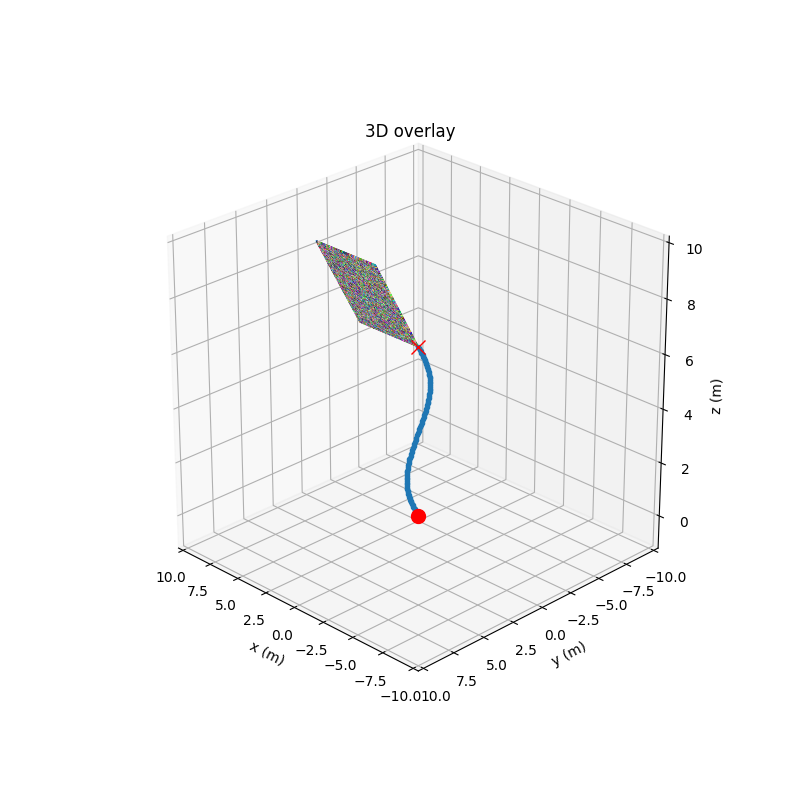

In [5]:
# import skimage
new_img=img

rnd_path_3d_x_temp = rnd_path_3d_x
rnd_path_3d_y_temp = rnd_path_3d_y
rnd_path_3d_z_temp = rnd_path_3d_z

%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

ax.plot(rnd_path_3d_x_temp, rnd_path_3d_y_temp, rnd_path_3d_z_temp, '.-', 
        zorder=9001)
ax.plot([rnd_path_3d_x_temp[0]], [rnd_path_3d_y_temp[0]], [rnd_path_3d_z_temp[0]], 'ro-', markersize=10,
       zorder=9001)
ax.plot([rnd_path_3d_x_temp[-1]], [rnd_path_3d_y_temp[-1]], [rnd_path_3d_z_temp[-1]], 'rx-', markersize=10,
       zorder=9001)

# https://github.com/matplotlib/matplotlib/issues/3894
# https://stackoverflow.com/questions/25931840/matplotlib-3d-background-always-on-top


imshow3D(new_img, xs=5, ys=5, rstride=1, cstride=1, 
         roll=np.pi/4, pitch=0, yaw=0, 
         translation = [rnd_path_3d_x[-1],
                        rnd_path_3d_y[-1],
                        rnd_path_3d_z[-1]])

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
plt.title("3D overlay")

ax.set_aspect('equal')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-1,10)

ax.elev=26 #90
ax.azim=135 #0
# plt.axis('off')
plt.show()
# plt.savefig("test.png")